# 08. Milestone Project 2: Pytorch Paper replicatig

The goal of machine learning paper replication is: turn a ML research paper into
usable code.

In this notebook, we're going to be replicating the Vision Transformer(ViT) architecture/paper with pytorch

## 0. Get setup

Let's import code we've previously written + required libraries.

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.0+cu118
torchvision version: 0.16.0+cu118


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
# Setup deviec agnostic code
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

##1. Get data

The whole goal of what we're trying to do is to replicate the ViT achitecture for our FoodVision mini problems

To do that, we need some data

Namely, the pizza, steak and sushi images we've been using so far



In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

In [6]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Create image size
IMG_SIZE = 224 # Comes from Table 3 of the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
# Create a bash size of 32(gthe paper uses 4096 but this may be too big for our small)
BATCH_SIZE = 8

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE

)

len(train_dataloader), len(test_dataloader), class_names

(29, 10, ['pizza', 'steak', 'sushi'])

### 2.3 visualize a single image

As Always, let's adhere to the motto, *Visusalize, Visusalize, Visusalize*

In [8]:
 # Get a batch of images
 image_batch, label_batch = next(iter(train_dataloader))

 # Get a single image and label from the batch
 image, label = image_batch[0], label_batch[0]

 # View the single image and label shape
 image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

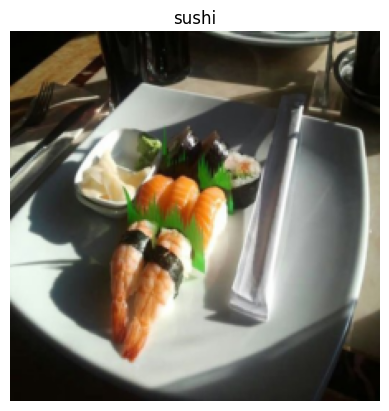

In [9]:
# Plot the image with matplotlib
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0)) # [C, H, W] -> [H, W, C]
plt.title(class_names[label])
plt.axis(False)

## 3.Replicating ViT: Overview

Looking at a whole machine learning research paper can be imtimidating.

So, in order to make it more understandable, we can break it down into smaller pieces

* **Inputs** - What goes into the model? (in our case, image tensors)
* **Outputs** - What comes out of the model/layer/block (in our case, we want model to output image classification labels)
* **Layers** - Takes a input,  manipulates it with a function(for example coud be self-attention).
* **Blocks** - A collections of layers
* **Models or (architecture)** - A collections of blocks

### 3.1 ViT overview: pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Four equations: Math equations which define the functions of each layer/block
* Table 1/3: Different hyperparameters for the architecture/training
* Text

### Figure 1

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png)

* Embendding = learnable representation (start with random numbers and imporve over time)

### Four equations

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png)

### Table
![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png)

#### 3.2.1 Exploring Figure 1

Let's start by going through Figure 1 of the ViT Paper.

The main things we'll be paying attention to are:
1. **Layers** - takes an **input**, performs an operation or function on the input, produces an **output**.
2. **Blocks** - a collection of layers, which in turn also takes an **input** and produces an **output**.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs.png" width=900 alt="figure 1 from the original vision transformer paper"/>

*Figure 1 from the ViT Paper showcasing the different inputs, outputs, layers and blocks that create the architecture. Our goal will be to replicate each of these using PyTorch code.*

The ViT architecture is comprised of several stages:
* **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in.
* **Linear projection of flattened patches (Embedded Patches)** - The image patches get turned into an **embedding**, the benefit of using an embedding rather than just the image values is that an embedding is a *learnable* representation (typically in the form of a vector) of the image that can improve with training.
* **Norm** - This is short for "[Layer Normalization](https://paperswithcode.com/method/layer-normalization)" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer [`torch.nn.LayerNorm()`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).
* **Multi-Head Attention** - This is a [Multi-Headed Self-Attention layer](https://paperswithcode.com/method/multi-head-attention) or "MSA" for short. You can create an MSA layer via the PyTorch layer [`torch.nn.MultiheadAttention()`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html).
* **MLP (or [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron))** - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a `forward()` method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two [`torch.nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers with a [`torch.nn.GELU()`](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) non-linearity activation in between them (section 3.1) and a [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layer after each (Appendex B.1).
* **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
* **MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

You might notice that many of the pieces of the ViT architecture can be created with existing PyTorch layers.

This is because of how PyTorch is designed, it's one of the main purposes of PyTorch to create reusable neural network layers for both researchers and machine learning practitioners.

> **Question:** Why not code everything from scratch?
>
> You could definitely do that by reproducing all of the math equations from the paper with custom PyTorch layers and that would certainly be an educative exercise, however, using pre-existing PyTorch layers is usually favoured as pre-existing layers have often been extensively tested and performance checked to make sure they run correctly and fast.

> **Note:** We're going to be focused on writing PyTorch code to create these layers. For the background on what each of these layers does, I'd suggest reading the ViT Paper in full or reading the linked resources for each layer.

Let's take Figure 1 and adapt it to our FoodVision Mini problem of classifying images of food into pizza, steak or sushi.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs-food-mini.png" width=900 alt="figure 1 from the original vision transformer paper adapted to work with food images, an image of pizza goes in and gets classified as 'pizza'"/>

*Figure 1 from the ViT Paper adapted for use with FoodVision Mini. An image of food goes in (pizza), the image gets turned into patches and then projected to an embedding. The embedding then travels through the various layers and blocks and (hopefully) the class "pizza" is returned.*

#### 3.2.2 Exploring the Four Equations

The next main part(s) of the ViT paper we're going to look at are the four equations in section 3.1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=650 alt="four mathematical equations from the vision transformer machine learning paper"/>

*These four equations represent the math behind the four major parts of the ViT architecture.*

Section 3.1 describes each of these (some of the text has been omitted for brevity, bolded text is mine):

| **Equation number** | **Description from ViT paper section 3.1** |
| ----- | ----- |
| 1 | ...The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a **trainable linear projection** (Eq. 1). We refer to the output of this projection as the **patch embeddings**... **Position embeddings** are added to the patch embeddings to retain positional information. We use standard **learnable 1D position embeddings**...|
| 2 | The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). **Layernorm (LN) is applied before every block**, and **residual connections after every block** (Wang et al., 2019; Baevski & Auli, 2019). |
| 3 | Same as equation 2. |
| 4 | Similar to BERT's [ class ] token, we **prepend a learnable embedding to the sequence of embedded patches** $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4)... |

Let's map these descriptions to the ViT architecture in Figure 1.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-mapping-the-four-equations-to-figure-1.png" width=1000 alt="mapping the vision transformer paper figure 1 to the four equations listed in the paper"/>

*Connecting Figure 1 from the ViT paper to the four equations from section 3.1 describing the math behind each of the layers/blocks.*

There's a lot happening in the image above but following the coloured lines and arrows reveals the main concepts of the ViT architecture.

How about we break down each equation further (it will be our goal to recreate these with code)?

In all equations (except equation 4), "$\mathbf{z}$" is the raw output of a particular layer:

1. $\mathbf{z}_{0}$ is "z zero" (this is the output of the initial patch embedding layer).
2. $\mathbf{z}_{\ell}^{\prime}$ is "z of a particular layer *prime*" (or an intermediary value of z).
3. $\mathbf{z}_{\ell}$ is "z of a particular layer".

And $\mathbf{y}$ is the overall output of the architecture.

#### 3.2.3 Equation 1 overview

$$
\begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}
$$

This equation deals with the class token, patch embedding and position embedding ($\mathbf{E}$ is for embedding) of the input image.

In vector form, the embedding might look something like:

```python
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]
```

Where each of the elements in the vector is learnable (their `requires_grad=True`).

#### 3.2.4 Equation 2 overview

$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's a Multi-Head Attention layer (MSA) wrapping a LayerNorm layer (LN).

The addition on the end is the equivalent of adding the input to the output and forming a [skip/residual connection](https://paperswithcode.com/method/residual-connection).

We'll call this layer the "MSA block".

In pseudocode, this might look like:

```python
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
```

Notice the skip connection on the end (adding the input of the layers to the output of the layers).

#### 3.2.5 Equation 3 overview

$$
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\end{aligned}
$$

This says that for every layer from $1$ through to $L$ (the total number of layers), there's also a Multilayer Perceptron layer (MLP) wrapping a LayerNorm layer (LN).

The addition on the end is showing the presence of a skip/residual connection.

We'll call this layer the "MLP block".

In pseudocode, this might look like:

```python
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

Notice the skip connection on the end (adding the input of the layers to the output of the layers).

#### 3.2.6 Equation 4 overview

$$
\begin{aligned}
\mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & &
\end{aligned}
$$

This says for the last layer $L$, the output $y$ is the 0 index token of $z$ wrapped in a LayerNorm layer (LN).

Or in our case, the 0 index of `x_output_MLP_block`:

```python
y = Linear_layer(LN_layer(x_output_MLP_block[0]))
```

Of course there are some simplifications above but we'll take care of those when we start to write PyTorch code for each section.

> **Note:** The above section covers alot of information. But don't forget if something doesn't make sense, you can always research it further. By asking questions like "what is a residual connection?".

#### 3.2.7 Exploring Table 1

The final piece of the ViT architecture puzzle we'll focus on (for now) is Table 1.

| Model | Layers | Hidden size $D$ | MLP size | Heads | Params |
| :--- | :---: | :---: | :---: | :---: | :---: |
| ViT-Base | 12 | 768 | 3072 | 12 | $86M$ |
| ViT-Large | 24 | 1024 | 4096 | 16 | $307M$ |
| ViT-Huge | 32 | 1280 | 5120 | 16 | $632M$ |

<div align=center>
    <i>Table 1: Details of Vision Transformer model variants. Source: <a href="https://arxiv.org/abs/2010.11929">ViT paper</a>.</i>
</div>
<br>

This table showcasing the various hyperparameters of each of the ViT architectures.

You can see the numbers gradually increase from ViT-Base to ViT-Huge.

We're going to focus on replicating ViT-Base (start small and scale up when necessary) but we'll be writing code that could easily scale up to the larger variants.

Breaking the hyperparameters down:
* **Layers** - How many Transformer Encoder blocks are there? (each of these will contain a MSA block and MLP block)
* **Hidden size $D$** - This is the embedding dimension throughout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embedded. Generally, the larger the embedding dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more compute.
* **MLP size** - What are the number of hidden units in the MLP layers?
* **Heads** - How many heads are there in the Multi-Head Attention layers?
* **Params** - What are the total number of parameters of the model? Generally, more parameters leads to better performance but at the cost of more compute. You'll notice even ViT-Base has far more parameters than any other model we've used so far.

We'll use these values as the hyperparameter settings for our ViT architecture.

## 4. Equation 1: Split data into patches and creating the class, position and patch embending

Layers = input -> function -> output

What's the input shape?
What's the output shape?

- Input shape: (224, 224, 3) -> single image -> (height, width, color_channels)
- Ouput shape:

The standard Transformer receives as input a 1D sequence of token embeddings.
To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$
into a sequence of flattened 2D patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$,
where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$
is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches,
which also serves as the effective input sequence length for the Transformer.
The Transformer uses constant latent vector size $D$ through all of its layers,
so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1).
 We refer to the output of this projection as the **patch embeddings**.

 Let's break down the text above.

* $D$ is the size of the **patch embeddings**, different values for $D$ for various sized ViT models can be found in Table 1.
* The image starts as 2D with size ${H \times W \times C}$.
    * $(H, W)$ is the resolution of the original image (height, width).
    * $C$ is the number of channels.
* The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.
    * $(P, P)$ is the resolution of each image patch (**patch size**).
    * $N=H W / P^{2}$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.

Remember:
- H = height
- W = width
- C = color channels
- P = path size
- N = number of patches = (height*width) / p^2

In [10]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height*width)//patch_size**2)
number_of_patches

196

In [11]:
# Input shape
embendding_layer_input_shape = (height, width, color_channels)

# Output shape
embendding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2d image): {embendding_layer_input_shape}")
print(f"Output shape (single 1d sequence of patches): {embendding_layer_output_shape} -> (numbre_of_patches, embendding_dimension)")

Input shape (single 2d image): (224, 224, 3)
Output shape (single 1d sequence of patches): (196, 768) -> (numbre_of_patches, embendding_dimension)


### 4.2 Turnin single image into patches

Let's visualize, vizualize, vizualize!

(-0.5, 223.5, 223.5, -0.5)

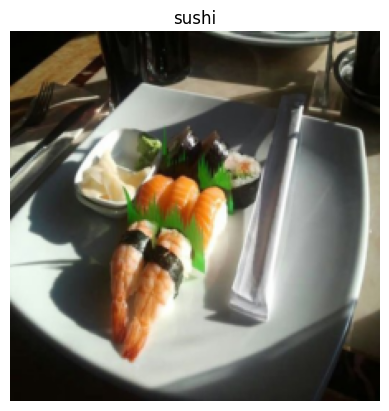

In [12]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [13]:
image.shape

torch.Size([3, 224, 224])

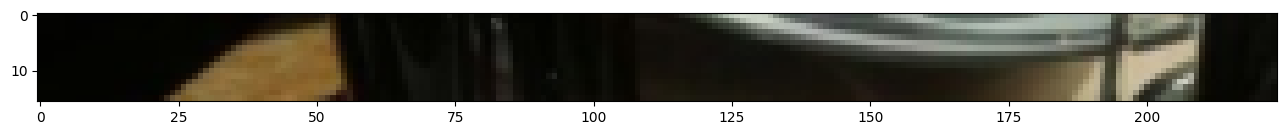

In [14]:
# Get the top row
image_permuted =  image.permute(1, 2, 0) # convert image to colour channel last

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14
Patch size: 16 pixels x 16 pixels


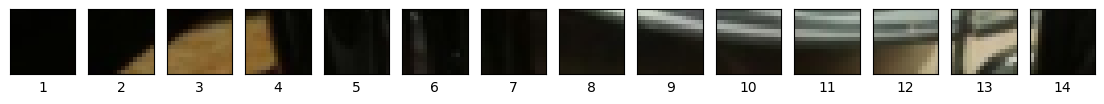

In [15]:
# Setup code to plot row as patches
img_size = 224
patch_size = 16
num_patches = img_size//patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                         ncols=num_patches, # One column for each patch
                         sharex=True,
                         sharey=True,
                         figsize=(num_patches, num_patches)
                         )

# Iterable through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1) # set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14        
Number of patches per column: 14        
Total patches: 196        
Patch size: 16 pixels x 16 pixels


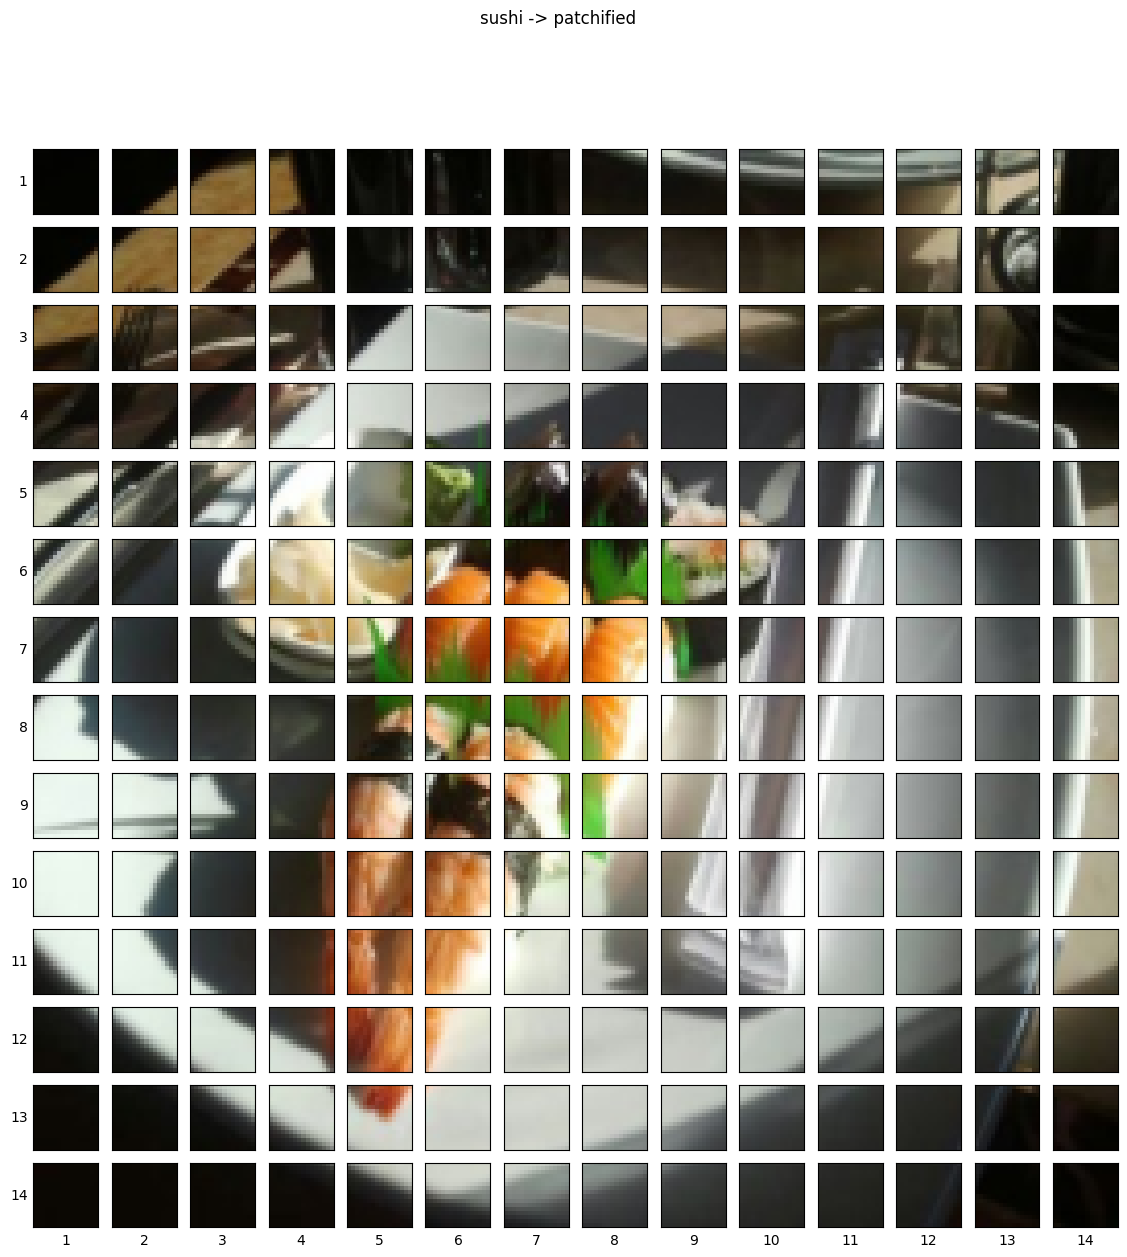

In [16]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size//patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Creates a series of subplots
fig, axs = plt.subplots(nrows=num_patches,
                        ncols=num_patches,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # Iterate through height
  for j, patch_width in enumerate(range(0, img_size, patch_size)): # Iterate through width
    # Plot the permuted image on the different axes
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # Height
                                          patch_width:patch_width+patch_size, # Width
                                          : # All color channels
                                          ])

    # Setup label information for each subplot(patch)
    axs[i, j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# Setup up a title for the plot
fig.suptitle(f"{class_names[label]} -> patchified")
plt.show()


### 4.3 Creating image patches and turning them into patchs embeddings

Perharps we could create the image patches and image patchs embenddings in single
step using `torch.nn.Conv2d()` and setting the kernerl size and stride parameters
to `patch_size`

In [17]:
# Create conv2d layer to turn image into patches of learnables feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

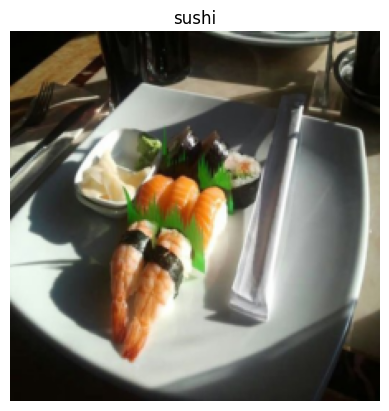

In [18]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [19]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # Add the batch dimention [batch_size, color_channles, height, width]
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now we've a single image to our `conv2d` layer, it's shape is:

```python
torch.Size([1, 768, 14, 14]) # [batch_size, embendding_dim, feature_map_height, feature_map_width]
```

In [20]:
image_out_of_conv.requires_grad

True

Showing random convolutional feature maps from indexes: [401, 515, 63, 637, 325]


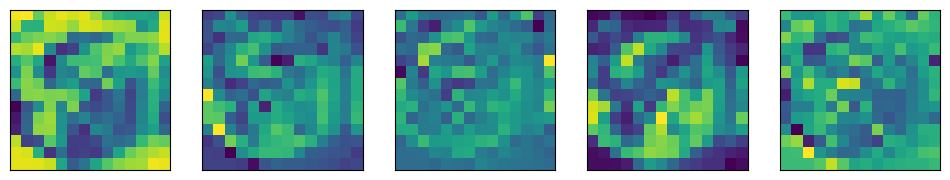

In [21]:
# Plot random convolutional feature maps (embenddings)
import random
random_features = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_features}")

# Create a plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_features):
  image_out_of_conv_map = image_out_of_conv[:, idx, :, :] # index on the outputof the conv2d layer
  axs[i].imshow(image_out_of_conv_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);


In [22]:
#
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.0354,  0.0390, -0.0395,  0.0396,  0.0196,  0.0270,  0.0255,
           -0.0401, -0.0250, -0.0614, -0.0672, -0.1188, -0.0048, -0.0160],
          [-0.0359, -0.0386,  0.0558,  0.0638,  0.0362,  0.0374,  0.0037,
            0.0251, -0.0203,  0.0111, -0.0361,  0.0143,  0.0798,  0.0290],
          [ 0.0155,  0.0350,  0.0813, -0.0278,  0.0638, -0.0211, -0.0938,
           -0.0159, -0.0601,  0.0003,  0.0548, -0.0119, -0.0123,  0.0120],
          [ 0.0239,  0.0531, -0.0067,  0.0582, -0.0543, -0.1066, -0.1501,
            0.0133,  0.0105,  0.0071,  0.0242,  0.0190,  0.1470,  0.0156],
          [-0.0615, -0.0354, -0.0010, -0.1973, -0.0253,  0.0101, -0.1141,
           -0.0198, -0.0161, -0.0469, -0.0425, -0.0334,  0.0094,  0.0593],
          [-0.1153,  0.0364, -0.1191, -0.1113, -0.0954, -0.1214, -0.1203,
           -0.0089, -0.0764, -0.0687, -0.0575, -0.0258, -0.0133, -0.0606],
          [-0.0662, -0.0009, -0.0850, -0.0802,  0.0052, -0.0258, -0.1171,
           -0.0029, -0.0489, -0.

##3.3 Flattening the patch embendding with `torch.nn.Flatten()`

Right now we've a series of convolutional fetures maps(patch embenddings) that
we want to flatten into a sequence of patche embenddings to satisfy the inpute
criteriaof the ViT transformer Encoder

In [23]:
print(f"{image_out_of_conv.shape} -> (batach_size, embendding_dim, feature_map_height, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batach_size, embendding_dim, feature_map_height, feature_map_width)


Want: (batch_size, number_of_patches, embendding_dim)

In [24]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


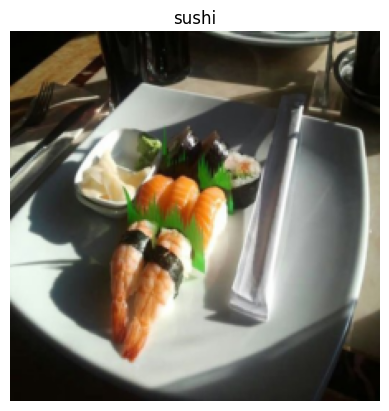

In [25]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [26]:
# Rearrange output of flattened layer
print(f"{image_out_of_conv_flattened.permute(0, 2, 1).shape} -> (batch_size, number_of_patches, embendding_dimension)")
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embendding_dimension)


(-0.5, 195.5, 0.5, -0.5)

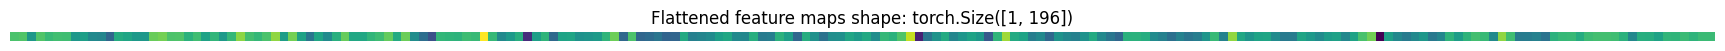

In [27]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0]

# Plot the flattened feature map
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature maps shape: {single_flattened_feature_map.shape}")
plt.axis(False)

### 4.5 Turning the ViT patch embendding layer into a PyTorch module

We want this module to do a few things:
1. Create a class called `PatchEmbedding` thats inherits from `nn.Module`
2. Initialize with appropriate hyperparameters, such as channels, embending dimension, patch size.
3. Create a layer to turn an image into embendding patches using `nn.Conv2d`
4. Create a layer to Flatten the fearure maps of the output of the layer in 3.
4. Definea `forward()` thats defines the forward computation (e.g pass through layer
from 3 and 4)
6. Make sure the output shape of the layer reflects the required output shape of
the patch embedding.

In [28]:
# 1. Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):
  # 2. Initialize the layer with appropriate hyperparameters()
  def __init__(self, in_channels: int=3, embedding_dim:int=768, patch_size: int=16): # From Table 1 for ViT-Base
    super().__init__()
    self.patch_size = patch_size

    # 3. Create a layer to turn an image into embedded patch
    self.patcher = nn.Conv2d(in_channels=in_channels,
                  out_channels=embedding_dim,
                  kernel_size=(patch_size, patch_size),
                  stride=patch_size,
                  padding=0)

    # 4. Create a layer to flatten feature map output  of conv2d
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  # 5. Define a forward method to define the forward computation steps
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    # 6. Make sure the output shape has the right order
    return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [29]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [30]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [31]:
# Create class token embedding as a learlable parameter that shares the same size as  the embedding dimention (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)

class_token.shape

torch.Size([1, 1, 768])

In [32]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0298, -0.0063, -0.0322,  ...,  0.0185, -0.0090,  0.0092],
         [-0.2239,  0.0199, -0.0241,  ...,  0.1530, -0.0877,  0.0157],
         ...,
         [-0.1131,  0.0228, -0.0625,  ...,  0.0849, -0.0809,  0.0354],
         [-0.0044, -0.0392, -0.0298,  ...,  0.0096, -0.0269,  0.0357],
         [-0.0313, -0.0086, -0.0443,  ...,  0.0430, -0.0086,  0.0028]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [33]:
patch_embedded_image_with_class_embedding[: ,:, 1]

tensor([[ 1.0000e+00, -6.3406e-03,  1.9945e-02,  4.8261e-02, -2.8613e-02,
          9.3669e-03, -7.6905e-03,  3.1071e-03,  1.5913e-01, -5.5035e-03,
          1.1157e-01,  1.4748e-01,  1.8860e-01, -4.4317e-02, -6.3668e-02,
         -1.6967e-02,  1.4969e-01,  1.5666e-02,  2.5944e-03,  4.0305e-03,
          4.8969e-02,  9.0970e-02,  6.2162e-02,  3.1824e-02,  2.2120e-02,
          7.7794e-02,  2.0792e-01, -2.3948e-02, -1.8967e-02,  1.2294e-01,
          5.9449e-02, -3.4759e-02,  2.3392e-02,  3.3929e-01,  1.4543e-01,
          1.8996e-01,  1.4715e-01,  1.3111e-01, -3.3072e-02, -1.2992e-03,
          1.2478e-01,  9.0563e-04, -3.2569e-02,  2.3489e-02, -4.0195e-02,
          1.5520e-01,  3.4448e-01,  2.0921e-01,  7.1333e-02,  1.3269e-01,
         -1.8918e-02,  4.1031e-02,  3.1568e-02,  3.3726e-01, -3.0691e-04,
          4.7120e-02, -1.2364e-01,  1.8283e-01, -3.2432e-02,  2.4700e-01,
          2.9199e-01,  6.2558e-04,  1.1467e-01,  2.3136e-01,  4.9427e-02,
          1.1635e-01,  1.2469e-01,  1.

### 4.7 Creating the position embedding

Want to: create a series of 1D learnable position embedding and to add them to sequence of patch embeddins

In [34]:
# View the sequence of patch embedding with the prepend class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0298, -0.0063, -0.0322,  ...,  0.0185, -0.0090,  0.0092],
          [-0.2239,  0.0199, -0.0241,  ...,  0.1530, -0.0877,  0.0157],
          ...,
          [-0.1131,  0.0228, -0.0625,  ...,  0.0849, -0.0809,  0.0354],
          [-0.0044, -0.0392, -0.0298,  ...,  0.0096, -0.0269,  0.0357],
          [-0.0313, -0.0086, -0.0443,  ...,  0.0430, -0.0086,  0.0028]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [35]:
# Calculate N (number_of_patches)
number_of_patches = int((width*height) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True
                                  )

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [36]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9702, 0.9937, 0.9678,  ..., 1.0185, 0.9910, 1.0092],
         [0.7761, 1.0199, 0.9759,  ..., 1.1530, 0.9123, 1.0157],
         ...,
         [0.8869, 1.0228, 0.9375,  ..., 1.0849, 0.9191, 1.0354],
         [0.9956, 0.9608, 0.9702,  ..., 1.0096, 0.9731, 1.0357],
         [0.9687, 0.9914, 0.9557,  ..., 1.0430, 0.9914, 1.0028]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


# 4.8 Putting it all together: from image to embedding

We've written code to turn an image in a flattened sequence of patch embeddings.

Now let's it all in one cell.

In [37]:
# Set seeds
set_seeds()

# 1. Set the patch size
patch_size = 16

# 2. Print shapes of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimesion
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create the patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: ", {patch_embedding.shape})

# 6. Create class token embedding.shape[-1]
batch_size = patch_embedding.shape[0]
embedding_dimesion = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# 9. Add the posstion embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape:  {torch.Size([1, 196, 768])}
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape torch.Size([1, 197, 768])
Patch and position embedding shape torch.Size([1, 197, 768])


## Equation 2: Multihead Self-Attention(MSA Block)

* Multihead self-attention: which part of a sequence should pay the most attetion to itself?
  * In our case, we haev a series of embedded images patches, which patch significantly relates to another patch.
  * We want our neural network(ViT) to lear this relationship/representation.
* To replicate MSA in PyTorch we can use `torch.nn.MultiHeadAttention`
* LayerNorm = Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
  * Normalization = make everyting have the same mean and same standard deviation
  * In PyTorch = https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html normalizes values over D dimension, in our case, the D dimension is the embedding dimension
    * When we normalize along the embedding dimension, it's like making all of the stairs in staircase the same size

In [38]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """Creates a multi-head self-attention block ("MSA Block" for short)
  """

  def __init__(self,
            embedding_dim: int=768, # Hidden size D (embedding dimesion) from Table 1 for ViT-Base
            num_heads: int=12, # Heads from Table 1 for ViT-Base
            attn_dropout: int=0
            ):

    super().__init__()

    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create multihead attention (MSA) layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True) # is the batch fist? (batch, seq, feature) -> (batch, number_of_patches, embedding_dimension)
  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                            key=x,
                            value=x,
                            need_weights=False)
    return attn_output


In [39]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12, # from Table 1
                                                             attn_dropout=0)

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


## 6.Equation 3: Multilayer Percepron (MLP block)

* **MLP** = the MLP contains two layers with a GeLU non-linearity (section 3.1)
  * MLP = a quite broad term for a block with a series of layer(s), layers can be multiple or even only one hidden layer
  * Layers can mean: fully-connected, dense linear, feed-forward, all are often similar names for the same thing, in PyTorch they're often called `torch.nn.Linear()` and in TensorFlow they might be called `tf.keras.layers.Dense()`
  * GeLU in PyTorch: https://pytorch.org/docs/stable/generated/torch.nn.GELU.html
  * MPL number of hidden units = MLP Size in Table 1
  

* **Dropout**: Dropout, when used, is applied after
every dense layer except for the the qkv-projections and directly after adding positional- to patch
embeddings. Hybrid models are trained with the exact setup as their ViT counterpart

```python
#MLP
x = linear ->non-linear -> dropout -> linear -> dropout
```

In [40]:
class MLPBlock(nn.Module):
  """Creates a multi-head self-attention block ("MSA Block" for short)
  """

  def __init__(self,
               embedding_dim: int=768, # Hidden size D (embedding dimesion) from Table 1 for ViT-Base
               mlp_size: int=3072,
               dropout: float=0.1
              ):

    super().__init__()

    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dimension, out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size, out_features=embedding_dimension),
        nn.Dropout(p=dropout)
    )


  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x
    #return self.mlp(self.layer_norm(x)) # Same as above


In [41]:
# Create a instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output the MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


## 7. Creating the Transformer Encoder

The Transformer Encoderis a combination of alternating block of MSA(equation 21) and MLP(equation 3).

And there are residual connections between each block

* Encoder = turn a sequence into a learnable representation
* Decoder = go from learn representation  back to some sort of sequence
* Residual connections = add a layer(s) input its subsequent output, this enables the creationof deeper networks (prevents weights from gettin too small)

In Psedocode:
```python
# Transformer Enconder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

### 7.1 Create a custom Transformer Enconder block

In [42]:
class TransformerEncoderBlock(nn.Module):
  """Creates a multi-head self-attention block ("MSA Block" for short)
  """

  def __init__(self,
               embedding_dim: int=768, # Hidden size D (embedding dimesion) from Table 1 for ViT-Base
               num_heads: int=12, # Heads from Table 1 for ViT-Base
               mlp_size: int=3072, # From table 1
               mlp_dropout: float=0.1, # From table 3
               attn_dropout: int=0
              ):

    super().__init__()

    # Create the MSA block
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dimension, # from Table 1
                                                             num_heads=num_heads, # from Table 1
                                                             attn_dropout=attn_dropout)

    # Create the MLP block
    self.mlp_block = MLPBlock(embedding_dim=embedding_dimension,
                     mlp_size=mlp_size,
                     dropout=mlp_dropout)

  def forward(self, x):

    x = self.msa_block(x) + x # residual/skip connection for equation 2
    x = self.mlp_block(x) + x # residual/skip connection for equation 3

    return x
    #return self.mlp(self.layer_norm(x)) # Same as above


In [43]:
# Create a instance of TransformerEncoderBlock()
transformer_encode_block = TransformerEncoderBlock()

# Get a summary using torchinfor.summary
summary(model=transformer_encode_block,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create a Transformer Encoder layer with in-build PyTorch layers

So far we've created a transformer encoder by hand.

But because of how goog Transformer architecture is, Pytorch has implemented
ready to use Transformer Encoder Layers(https://pytorch.org/docs/stable/nn.html#transformer-layers)

We can create a Transformer Encoder with pure Pytorch layers(https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html)

In [44]:
# Create the same as above torch.nn.TransformerEnconderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # embedding size from table 1
                                                            nhead=12, # heads from tanle 1
                                                            dim_feedforward=3072, # MLP size from table
                                                            dropout=0.1,
                                                            activation='gelu',
                                                            batch_first=True,
                                                            norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [45]:
# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
         input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

Why spend all this time recreating the transformer encoder when we could've just made it with a single pytorch layer?

Practice,Practice,Practice

Now we know how things are implemented behind the scenes, we can tweak them if necessary.

What are the benefitis of using a pre-build PyTorch layer?

* Less prone to erros(goes through a bunch of testing)
* Potential benefit of speed ups (performance boost)

## 8. Putting it all together to create ViT

In [46]:
# Create ViT
class ViT(nn.Module):
  def __init__(self,
               img_size: int=224, # Table 3 from the ViT paper
               in_channels: int=3,
               patch_size: int=16,
               num_transformer_layers: int=12, # Table 1
               embedding_dim=768, # Hidden size D from Table 1 for ViT-Base
               mlp_size: int=3072, # Table 1
               num_heads: int=12, # Table 1
               attn_dropout: int=0,
               mlp_dropout: float=0.1,
               embedding_dropout: float=0.1, # Dropout for patch and position embeddings
               num_classes: int=1000):

    super().__init__()

    # Make an assertion that the image is compatible with the pacht size
    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch_size: {patch_size}"

    # Calculate the number of patches (height * width) / patch_size**2
    self.num_patches = (height * width) // patch_size**2

    # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

    # Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                           requires_grad=True)

    # Create embedding dropout
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create embedding dropout value
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # Create the Transformer Encoder block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                      num_heads=num_heads,
                                                                      mlp_size=mlp_size,
                                                                      mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

    # Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get batch size
    batch_size = x.shape[0]

    # ?????
    # Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" mean to infer the dimentions

    # Create the patch embedding (equation 1)
    x = self.patch_embedding(x)

    # Concat class token embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim=1) # (batch_size, number_of_patches+1, embedding_dim)

    # Add position embedding to class token and patch embedding
    x = self.position_embedding + x

    # Apply droput to patch embedding ("directly after adding positional to patche")
    x = self.embedding_dropout(x)

    # Pass postion and patch embedding to Transformer Encoder (equation 2 & 3)
    x = self.transformer_encoder(x)

    # Put 0th logit through classifier(equation 4)
    x = self.classifier(x[:, 0])

    return x

In [47]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

In [48]:
set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we're working with (pizza, steak and sushi)
vit = ViT(num_classes=3)

# Pass the random image to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

## 8.1 Gettin a visual summary of our ViT model

In [49]:
summary(model=vit,
         input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

## 9. Setting up training code for our custom ViT

We've replicated the ViT architecture, now let's see how it performs on our FoodVision Mini data

### 9.1 Creating an optimizer

The paper states it uses the Adam optimizer (section 4, Training & fine-tuning) with $B1$ value of 0.9 $B2$ of 0.999 (defaults) and a weight decay of 0.1.

Weight decay = Weight decay is a regularization technique by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function.

Regularization techinique = prevents overfitting

In [50]:
optimizer = torch.optim.Adam(vit.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=0.1)

### 9.2 Creating a loss function

The ViT paper doesn't actually mention what loss function they used

So since it's a multi-class classification we'll use the `torch.nn.CrossEmntropuLoss()`.

In [51]:
loss_fn = torch.nn.CrossEntropyLoss()

### 9.3 Training our ViT Model

In [52]:
from going_modular.going_modular import engine

set_seeds()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=5,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0217 | train_acc: 0.3836 | test_loss: 4.0852 | test_acc: 0.3125
Epoch: 2 | train_loss: 1.4200 | train_acc: 0.3362 | test_loss: 1.1833 | test_acc: 0.2375
Epoch: 3 | train_loss: 1.2378 | train_acc: 0.3017 | test_loss: 1.1180 | test_acc: 0.4500
Epoch: 4 | train_loss: 1.1376 | train_acc: 0.3276 | test_loss: 1.4953 | test_acc: 0.3125


KeyboardInterrupt: ignored

### 9.4 What our training setup is missing

How is our training setup differentto the ViT paper?

We've replicated model architecture correctly.

But what was different between our training procedure (to get such poor results)
and the ViT paper training procedure to get such great results?

The main things our training procedure is missing:

Prevent underfitting:
* Data - our setup uses far less data (255 vs millions)

Prevent overfitting:
* Learning rate warmaps - start with a low learning rate and increase to a base LR
* Learning rate decay - as your model gets closer to convergence, start lower the
learning rate
* Gradient clipping - prevent gradients from getting too big

Search "PyTorch [technique name]"

### 9.5 Plotting loss curves for our model

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 10. Using a pretreined ViT from `torchvision.models`

Generally, in deep learning if you can use a pretreined model from a large data set on your own problem, it's often a good place to start.

If your can find a pretreined model, and use transfer learning, give it a go, it often achieves greats results with little data



### 10.1 **Why use a pretreined model?**

* Sometimes data is limited
* Limited training resources
* Get better results faster (sometimes)...

### 10.2 Prepare a pretrained ViT for use with FoodVision Mini (turn it  into a feature extractor)

In [61]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Get pretreined weights for ViT-Base
vit_weights =  ViT_B_16_Weights.DEFAULT

pretrained_vit = vit_b_16(weights=vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

# Update the classifier head
set_seeds()
pretrained_vit.heads = torch.nn.Linear(in_features=768, out_features=len(class_names))

In [62]:
summary(model=pretrained_vit,
         input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [ ]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

### 10.3 Preparing data for the pretrained ViT model

When using a pretrained model, you want to make sure your data is formatted in the same way that the model was treined on.

In [63]:
# Get automatic transforms from pretrained ViT weights
vit_transforms = vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [64]:
# Setup dataloaders
from going_modular.going_modular import data_setup
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                  test_dir=test_dir,
                                                                                                  transform=vit_transforms,
                                                                                                  batch_size=8)

### 10.4 Train feature extractor ViT model

In [67]:
from going_modular.going_modular import engine

set_seeds()

# Create optimizer and loss function
optimizer2 = torch.optim.Adam(pretrained_vit.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=0.1)
loss_fn2 = torch.nn.CrossEntropyLoss()

results = engine.train(model=pretrained_vit,
                       train_dataloader=train_dataloader_pretrained,
                       test_dataloader=test_dataloader_pretrained,
                       epochs=5,
                       optimizer=optimizer2,
                       loss_fn=loss_fn2,
                       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5141 | train_acc: 0.8103 | test_loss: 0.2352 | test_acc: 0.9375
Epoch: 2 | train_loss: 0.1676 | train_acc: 0.9569 | test_loss: 0.1881 | test_acc: 0.9375
Epoch: 3 | train_loss: 0.1160 | train_acc: 0.9741 | test_loss: 0.1748 | test_acc: 0.9375
Epoch: 4 | train_loss: 0.0868 | train_acc: 0.9871 | test_loss: 0.1661 | test_acc: 0.9375
Epoch: 5 | train_loss: 0.0709 | train_acc: 0.9914 | test_loss: 0.1673 | test_acc: 0.9375


### 10.5 Plot the loss curves of our pretrained ViT feature extractor model

In [ ]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

### 10.6 Save our best performance ViT model

Now we've got a model that performs quit well, how about we save it to file and check it's filesize.

We want to check the file size because if we wanted to deploy a model to say a website/mobile application, we may limitations on the size of the model we can deploy

E.g a smaller model may be required due to compute restrictions.

In [ ]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                target_dir='models',
                 model_name='08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth')

In [ ]:
from pathlib import Path

pretrained_vit_model_size = Path('08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth').stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretraine_vit_model_size}")

### 11. Predicting on a custom image


Our pretrained ViT gets some of the best results we've seen so far on our FooVision Mini problem, however, the model size is ~11x larger than our next best performing model.

Perphaps the larger model size might cause issues when we go to deploy(e.g hardware to deploy such a large file/might predicitions as fast as a  smaller model)

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)